In [6]:
#import all the modeules we've used before

import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import rdkit
# Render the figure in a notebook:
%matplotlib inline  

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score

In [7]:
df = pd.read_csv('tox21.csv')
#make two toxicity scores based on NR and SR assay response.
df['NR_tox_score'] = df['NR-AR']+df['NR-AR-LBD']+df['NR-AhR']+df['NR-Aromatase']+df['NR-ER']+df['NR-ER-LBD']+df['NR-PPAR-gamma']
df['SR_tox_score'] = df['SR-ARE']+df['SR-ATAD5']+df['SR-HSE']+df['SR-MMP']+df['SR-p53']
df_no_nan = df.dropna()
df_dropped_Al = df.drop([1322, 2290,2297,3558, 4565,4649, 5538, 6723, 7830]) #we dropped these values, they're no longer there


In [8]:
# https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html
from rdkit.Chem import Descriptors
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [11]:
desc_list = []
for molecule in range(len(df_dropped_Al)):
    desc_list.append(getMolDescriptors(Chem.MolFromSmiles(df_dropped_Al.iloc[molecule]['smiles'])))


[13:48:13] WARNING: not removing hydrogen atom without neighbors
[13:48:13] WARNING: not removing hydrogen atom without neighbors


In [10]:
df_dropped_Al_desc = pd.DataFrame(desc_list)
df_dropped_Al_desc
#this is now a list containing all the descriptors

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.107593,11.107593,0.073011,-3.723219,0.900283,11.875000,258.324,248.244,258.013284,86,...,0,1,0,0,0,1,0,0,0,0
1,11.790004,11.790004,0.172500,-0.515139,0.738013,20.600000,204.229,192.133,204.089878,78,...,0,0,0,0,0,0,0,0,0,1
2,11.165775,11.165775,0.207144,-0.369724,0.666269,52.619048,288.475,256.219,288.245316,118,...,0,0,0,0,0,0,0,0,0,0
3,12.570517,12.570517,0.042633,-0.042633,0.822261,12.500000,276.424,248.200,276.220164,112,...,0,0,0,0,0,0,0,0,0,0
4,10.251875,10.251875,0.383488,-5.197724,0.365583,15.090909,206.027,197.963,205.974526,68,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7817,12.539546,12.539546,0.053751,-0.598123,0.486536,11.920000,341.451,314.235,341.199094,134,...,0,0,0,0,0,0,0,0,0,0
7818,11.819107,11.819107,0.191822,-1.001242,0.392116,11.060606,440.463,420.303,440.159689,164,...,0,0,0,0,1,0,0,0,0,0
7819,12.146718,12.146718,0.245103,0.245103,0.701319,49.000000,314.469,284.229,314.224580,126,...,0,0,0,0,0,0,0,0,0,0
7820,11.787348,11.787348,0.082288,-0.082288,0.734230,52.714286,288.431,260.207,288.208930,116,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#recombine so this now contains SMILES, and ID.
df_dropped_Al_desc['smiles'] = df_dropped_Al['smiles']
df_dropped_Al_desc['mol_id'] = df_dropped_Al['mol_id']
df_dropped_Al_desc

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,smiles,mol_id
0,11.107593,11.107593,0.073011,-3.723219,0.900283,11.875000,258.324,248.244,258.013284,86,...,0,0,0,1,0,0,0,0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,TOX3021
1,11.790004,11.790004,0.172500,-0.515139,0.738013,20.600000,204.229,192.133,204.089878,78,...,0,0,0,0,0,0,0,1,CCN1C(=O)NC(c2ccccc2)C1=O,TOX3020
2,11.165775,11.165775,0.207144,-0.369724,0.666269,52.619048,288.475,256.219,288.245316,118,...,0,0,0,0,0,0,0,0,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,TOX3024
3,12.570517,12.570517,0.042633,-0.042633,0.822261,12.500000,276.424,248.200,276.220164,112,...,0,0,0,0,0,0,0,0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,TOX3027
4,10.251875,10.251875,0.383488,-5.197724,0.365583,15.090909,206.027,197.963,205.974526,68,...,0,0,0,0,0,0,0,0,CC(O)(P(=O)(O)O)P(=O)(O)O,TOX20800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7817,12.539546,12.539546,0.053751,-0.598123,0.486536,11.920000,341.451,314.235,341.199094,134,...,0,0,0,0,0,0,0,0,CCCn1cnc2c1c(=O)n(CCCCC(C)=O)c(=O)n2C,TOX25189
7818,11.819107,11.819107,0.191822,-1.001242,0.392116,11.060606,440.463,420.303,440.159689,164,...,0,0,1,0,0,0,0,0,c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1,TOX25188
7819,12.146718,12.146718,0.245103,0.245103,0.701319,49.000000,314.469,284.229,314.224580,126,...,0,0,0,0,0,0,0,0,Cc1ccc(=O)n(-c2ccccc2)c1,TOX25183
7820,11.787348,11.787348,0.082288,-0.082288,0.734230,52.714286,288.431,260.207,288.208930,116,...,0,0,0,0,0,0,0,0,Cc1nc2ccccn2c(=O)c1CCN1CCC(C(=O)c2ccc(F)cc2)CC1,TOX25182


In [ ]:
df=df_dropped_Al_desc
x= df.drop(columns=['smiles','mol_id'])
y= df[['smiles']]

<Axes: >

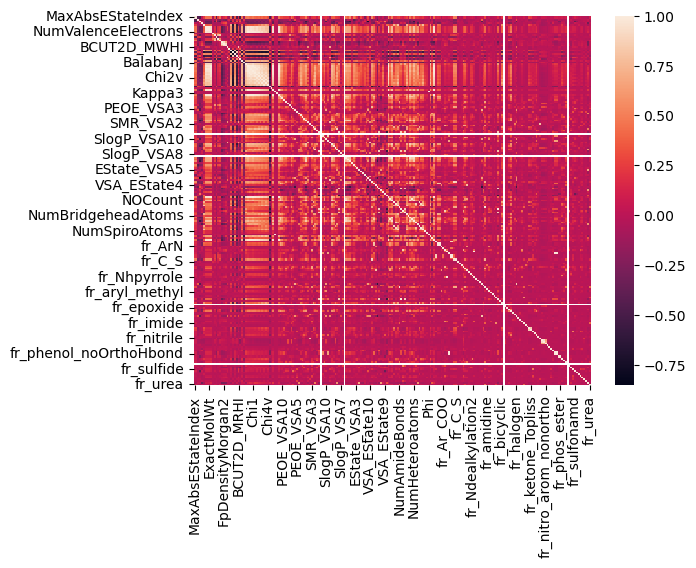

In [35]:
import seaborn as sns
corr=x.corr()
sns.heatmap(corr)